# Load VAE

In [1]:
!git clone https://github.com/Ahnd6474/ESMS-VAE

Cloning into 'ESMS-VAE'...
remote: Enumerating objects: 474, done.
remote: Counting objects: 100% (86/86), done.
remote: Compressing objects: 100% (68/68), done.
remote: Total 474 (delta 47), reused 17 (delta 17), pack-reused 388 (from 1)
Receiving objects: 100% (474/474), 396.44 MiB | 26.86 MiB/s, done.
Resolving deltas: 100% (116/116), done.
Updating files: 100% (248/248), done.


In [2]:
%cd /kaggle/working/ESMS-VAE

/kaggle/working/ESMS-VAE


In [3]:
!pip install -r requirements.txt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 957.3 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 72.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 89.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.9.41
    Uninstalling nvidia-nvjitlink-cu12-12.9.41:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.9.41
  Attempting uninstall: nvidia-curand-cu12
    Found existing inst

In [4]:
import glob
import os
from typing import List, Tuple

import pandas as pd
import torch
from torch.utils.data import DataLoader
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

from vae_module import (
    Config,
    Tokenizer,
    load_vae,
    SequenceDataset,
    pad_collate,
    encode_batch,
)

def encode_sequences(sequences: List[str], cfg: Config, tokenizer: Tokenizer, model) -> torch.Tensor:
    """Encode sequences into latent vectors using the VAE model."""
    # Sequences longer than max len were previously filtered and removed
    truncated = sequences
    dataset = SequenceDataset(truncated, tokenizer, cfg.max_len)
    loader = DataLoader(
        dataset,
        batch_size=cfg.batch_size,
        collate_fn=lambda batch: pad_collate(batch, tokenizer.pad_idx),
    )
    return encode_batch(model, loader, tokenizer)

def extract_Z(seq,vae):
    vae.eval()
    Z_list= []
    dataset = SequenceDataset(seq, tokenizer, cfg.max_len)
    loader = DataLoader(
        dataset,
        batch_size=cfg.batch_size,
        collate_fn=lambda batch: pad_collate(batch, tokenizer.pad_idx),
    )
    with torch.no_grad():
        for seq_batch in loader:
            seq_batch = seq_batch.to(device)
            reps, mask = vae.encoder(seq_batch)
            mask = mask.unsqueeze(-1)
            reps = reps * mask.float()
            summed = reps.sum(dim=1)
            counts = mask.sum(dim=1).clamp(min=1)
            z = (summed / counts).cpu().numpy()
            Z_list.append(z)

    return np.vstack(Z_list)



# Load Data

,sequence,DMS_score
0,HFKLLSKLLVYLTASIMAIASPLAFSVDSSGEYPTVSEIPVGEVRL...,-3.189795
1,AFKLLSKLLVYLTASIMAIASPLAFSVDSSGEYPTVSEIPVGEVRL...,-3.636189
2,CFKLLSKLLVYLTASIMAIASPLAFSVDSSGEYPTVSEIPVGEVRL...,-3.462681
3,DFKLLSKLLVYLTASIMAIASPLAFSVDSSGEYPTVSEIPVGEVRL...,-3.653086
4,EFKLLSKLLVYLTASIMAIASPLAFSVDSSGEYPTVSEIPVGEVRL...,-3.093605
...,...,...
4999,MFKLLSKLLVYLTASIMAIASPLAFSVDSSGEYPTVSEIPVGEVRL...,-3.358516
5000,MFKLLSKLLVYLTASIMAIASPLAFSVDSSGEYPTVSEIPVGEVRL...,-0.796534
5001,MFKLLSKLLVYLTASIMAIASPLAFSVDSSGEYPTVSEIPVGEVRL...,-3.696933
5002,MFKLLSKLLVYLTASIMAIASPLAFSVDSSGEYPTVSEIPVGEVRL...,-1.092555


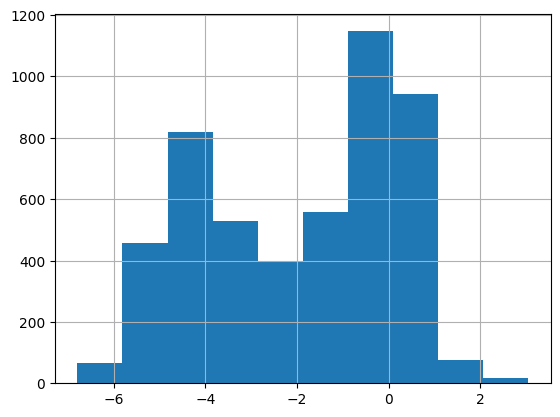

In [5]:
df=pd.read_csv(r'/kaggle/input/dms-subs/DMS_ProteinGym_substitutions/A4GRB6_PSEAI_Chen_2020.csv')
df['sequence']=df['mutated_sequence']
df=df[['sequence','DMS_score']]
df['DMS_score'].hist()
df

In [6]:
import pandas as pd
df.dropna(subset=['sequence','DMS_score'], inplace=True)

# 2) Recompute the true sequence length (just in case the CSV’s 'len' is stale)
df['true_len'] = df['sequence'].str.len()
df = df[df['true_len'] <= 512].reset_index(drop=True)
print('loaded_data')
df

loaded_data


,sequence,DMS_score,true_len
0,HFKLLSKLLVYLTASIMAIASPLAFSVDSSGEYPTVSEIPVGEVRL...,-3.189795,266
1,AFKLLSKLLVYLTASIMAIASPLAFSVDSSGEYPTVSEIPVGEVRL...,-3.636189,266
2,CFKLLSKLLVYLTASIMAIASPLAFSVDSSGEYPTVSEIPVGEVRL...,-3.462681,266
3,DFKLLSKLLVYLTASIMAIASPLAFSVDSSGEYPTVSEIPVGEVRL...,-3.653086,266
4,EFKLLSKLLVYLTASIMAIASPLAFSVDSSGEYPTVSEIPVGEVRL...,-3.093605,266
...,...,...,...
4999,MFKLLSKLLVYLTASIMAIASPLAFSVDSSGEYPTVSEIPVGEVRL...,-3.358516,266
5000,MFKLLSKLLVYLTASIMAIASPLAFSVDSSGEYPTVSEIPVGEVRL...,-0.796534,266
5001,MFKLLSKLLVYLTASIMAIASPLAFSVDSSGEYPTVSEIPVGEVRL...,-3.696933,266
5002,MFKLLSKLLVYLTASIMAIASPLAFSVDSSGEYPTVSEIPVGEVRL...,-1.092555,266


# Latent vector caculation

In [7]:
import numpy as np
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
cfg = Config(model_path="models/vae_epoch380.pt")
print(cfg)
tokenizer = Tokenizer.from_esm()
model = load_vae(
        cfg,
        vocab_size=len(tokenizer.vocab),
        pad_idx=tokenizer.pad_idx,
        bos_idx=tokenizer.bos_idx,)
model.to(device)
#if device == "cuda" and torch.cuda.device_count() > 1:
#model = torch.nn.DataParallel(model)

dms, sequences = df['DMS_score'].to_list(),df['sequence'].to_list()
Z = encode_sequences(sequences, cfg, tokenizer, model).cpu().numpy()
z=extract_Z(sequences,model)
print('Sequence encoding complete')

cuda
Config(model_path='models/vae_epoch380.pt', device='cpu', batch_size=64, max_len=512)


2025-06-23 14:23:06 vae_module.loader [INFO] Loaded VAE from models/vae_epoch380.pt on cpu
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:508: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. We recommend specifying layout=torch.jagged when constructing a nested tensor, as this layout receives active development, has better operator coverage, and works with torch.compile. (Triggered internally at /pytorch/aten/src/ATen/NestedTensorImpl.cpp:178.)
  output = torch._nested_tensor_from_mask(
/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Sequence encoding complete


/tmp/ipykernel_19/1179328208.py:25: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(


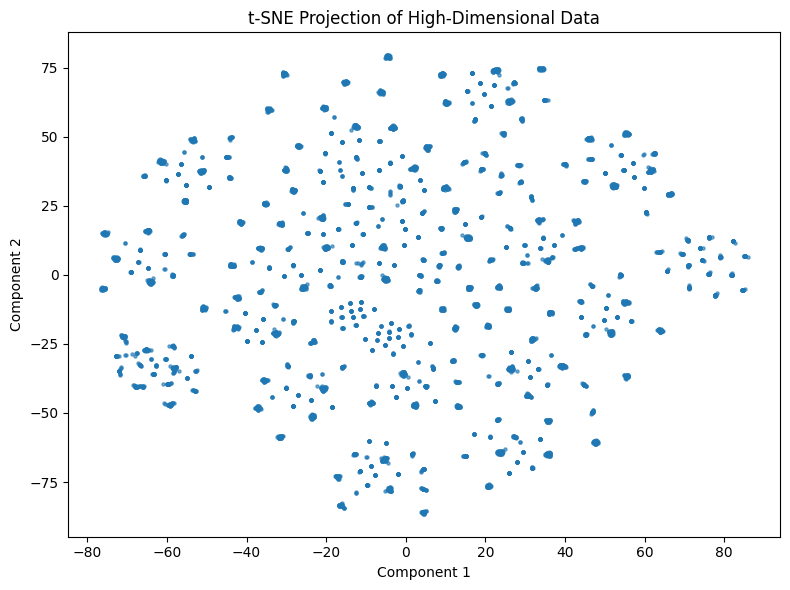

In [8]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# 1) 고차원 데이터 준비 (예: 1000샘플 × 50차원)
#    실제로는 사용자 데이터로 대체하세요.
X = z

# 2) t-SNE 모델 생성
tsne = TSNE(
    n_components=2,      # 투영 차원 (2 또는 3)
    perplexity=30,       # 주변 이웃의 수에 대한 추정 (5~50 사이 추천)
    learning_rate=200,   # 학습률 (10~1000 사이 시험)
    n_iter=1000,         # 반복 횟수 (500 이상 권장)
    init='pca',          # 초기화 방법 (’pca’ 또는 ‘random’)
    random_state=42      # 재현성 확보
)

# 3) 임베딩 계산 (X → X_embedded)
X_embedded = tsne.fit_transform(X)
# 결과 shape: (1000, 2)

# 4) 2D 결과 시각화
plt.figure(figsize=(8, 6))
plt.scatter(
    X_embedded[:, 0], X_embedded[:, 1],
    s=5,                # 점 크기
    alpha=0.6,          # 투명도
    cmap='viridis'      # 컬러맵 (numeric label이 있을 때)
)
plt.title('t-SNE Projection of High-Dimensional Data')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.tight_layout()
plt.show()


In [9]:
import numpy as np
import pandas as pd

# 가정: X는 (n_samples, n_features) 형태의 numpy array
# 예) X = np.load('latent_vectors.npy')
X=z
means = X.mean(axis=0)
stds  = X.std(axis=0, ddof=0)

# 차원별로 DataFrame으로 보기
df_stats = pd.DataFrame({
    'latent_dim': np.arange(X.shape[1]),
    'mean': means,
    'std': stds
})

# 상위 10개 차원만 출력
print(df_stats.head(10))

# 전체 분포 요약
print("\n전체 차원 요약:")
print(f"  means  → 평균 of means: {means.mean():.4f}, std of means: {means.std():.4f}")
print(f"  stds   → 평균 of stds:  {stds.mean():.4f}, std of stds:  {stds.std():.4f}")


   latent_dim      mean       std
0           0  0.003325  0.000339
1           1  0.049950  0.000219
2           2  0.032280  0.000182
3           3  0.034693  0.000558
4           4  0.030392  0.000248
5           5 -0.127681  0.000225
6           6  0.007626  0.000761
7           7  0.059609  0.000257
8           8 -0.014202  0.000495
9           9  0.060259  0.000380

전체 차원 요약:
  means  → 평균 of means: -0.0051, std of means: 0.2021
  stds   → 평균 of stds:  0.0004, std of stds:  0.0002


Epoch 010 | Train MSE: 0.5370 | Val MSE: 0.6396
Epoch 020 | Train MSE: 0.4723 | Val MSE: 0.6074
Epoch 030 | Train MSE: 0.4135 | Val MSE: 0.6078
Epoch 040 | Train MSE: 0.3858 | Val MSE: 0.5897
Epoch 050 | Train MSE: 0.3486 | Val MSE: 0.5900
Epoch 060 | Train MSE: 0.3452 | Val MSE: 0.5714
Epoch 070 | Train MSE: 0.3198 | Val MSE: 0.5896
Epoch 080 | Train MSE: 0.2981 | Val MSE: 0.5841
Epoch 090 | Train MSE: 0.2882 | Val MSE: 0.5914
Epoch 100 | Train MSE: 0.2756 | Val MSE: 0.5940
Epoch 110 | Train MSE: 0.2582 | Val MSE: 0.5744
Epoch 120 | Train MSE: 0.2461 | Val MSE: 0.5742
Epoch 130 | Train MSE: 0.2410 | Val MSE: 0.5891
Epoch 140 | Train MSE: 0.2372 | Val MSE: 0.5732
Epoch 150 | Train MSE: 0.2156 | Val MSE: 0.5962
Epoch 160 | Train MSE: 0.2145 | Val MSE: 0.5756
Epoch 170 | Train MSE: 0.2071 | Val MSE: 0.5874
Epoch 180 | Train MSE: 0.2022 | Val MSE: 0.5642
Epoch 190 | Train MSE: 0.1980 | Val MSE: 0.5804
Epoch 200 | Train MSE: 0.1878 | Val MSE: 0.5764
Epoch 210 | Train MSE: 0.1875 | Val MSE:

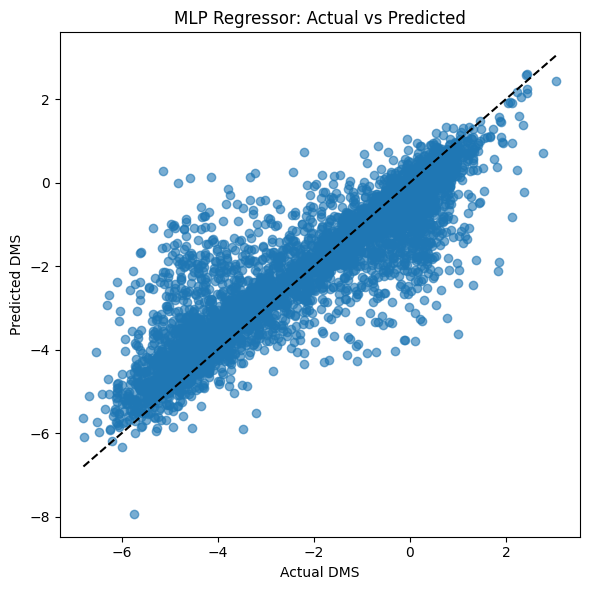

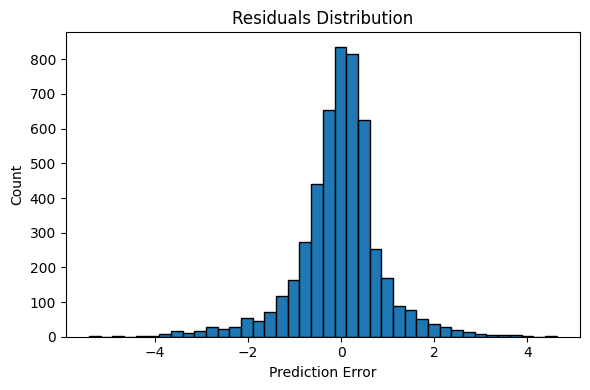

In [10]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, random_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# --- 1. 데이터 준비 ---
X = z.astype(np.float32)                # (n_samples, n_features)
y = np.array(dms, dtype=np.float32).reshape(-1,1)  # (n_samples, 1)

# --- 2. 스케일링 ---
X_scaler = StandardScaler()
y_scaler = StandardScaler()
X_scaled = X_scaler.fit_transform(X)
y_scaled = y_scaler.fit_transform(y)

# --- 3. Torch Dataset & DataLoader ---
dataset = TensorDataset(
    torch.from_numpy(X_scaled),
    torch.from_numpy(y_scaled)
)

# train/val split
n_total = len(dataset)
n_train = int(n_total*0.8)
n_val   = n_total - n_train
train_ds, val_ds = random_split(dataset, [n_train, n_val])
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=64)

# --- 4. 모델 정의 ---
class MLPRegressor(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 1)
        )
    def forward(self, x):
        return self.net(x)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MLPRegressor(X.shape[1]).to(device)

# --- 5. 손실 및 옵티마이저 ---
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# --- 6. 학습 루프 ---
n_epochs = 300
best_val_loss = float('inf')

for epoch in range(1, n_epochs+1):
    model.train()
    train_losses = []
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        pred = model(xb)
        loss = criterion(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    # validation
    model.eval()
    val_losses = []
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            pred = model(xb)
            val_losses.append(criterion(pred, yb).item())
    train_loss = np.mean(train_losses)
    val_loss   = np.mean(val_losses)
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_mlp.pth')
    if epoch % 10 == 0:
        print(f"Epoch {epoch:03d} | Train MSE: {train_loss:.4f} | Val MSE: {val_loss:.4f}")

# --- 7. 테스트 및 평가 ---
model.load_state_dict(torch.load('best_mlp.pth'))
model.eval()
X_tensor = torch.from_numpy(X_scaled).to(device)
with torch.no_grad():
    y_pred_scaled = model(X_tensor).cpu().numpy()

# 역변환
y_pred = y_scaler.inverse_transform(y_pred_scaled)
y_true = y

mse = mean_squared_error(y_true, y_pred)
r2  = r2_score(y_true, y_pred)
print(f"\nFinal MSE: {mse:.2f}, R²: {r2:.2f}")

# --- 8. 시각화: Actual vs Predicted ---
plt.figure(figsize=(6,6))
plt.scatter(y_true, y_pred, alpha=0.6)
mn, mx = y_true.min(), y_true.max()
plt.plot([mn,mx], [mn,mx], 'k--')
plt.xlabel('Actual DMS')
plt.ylabel('Predicted DMS')
plt.title('MLP Regressor: Actual vs Predicted')
plt.tight_layout()
plt.show()

# Residual histogram
residuals = (y_true - y_pred).ravel()
plt.figure(figsize=(6,4))
plt.hist(residuals, bins=40, edgecolor='black')
plt.title('Residuals Distribution')
plt.xlabel('Prediction Error')
plt.ylabel('Count')
plt.tight_layout()
plt.show()


2025-06-23 14:24:31 vae_module.loader [INFO] Loaded VAE from models/vae_epoch380.pt on cpu
/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


OTU7A_HUMAN_Tsuboyama_2023_2L2D.csv: MSE=0.653, R2=0.166, rho=0.794


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


SDA_BACSU_Tsuboyama_2023_1PV0.csv: MSE=0.386, R2=0.736, rho=0.937


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


SQSTM_MOUSE_Tsuboyama_2023_2RRU.csv: MSE=0.398, R2=0.490, rho=0.904
BBC1_YEAST_Tsuboyama_2023_1TG0.csv: MSE=0.813, R2=0.283, rho=0.881


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


SUMO1_HUMAN_Weile_2017.csv: MSE=0.116, R2=0.131, rho=0.773


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


P53_HUMAN_Giacomelli_2018_Null_Nutlin.csv: MSE=0.801, R2=0.202, rho=0.707


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


A0A247D711_LISMN_Stadelmann_2021.csv: MSE=1.609, R2=0.207, rho=0.717


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


ESTA_BACSU_Nutschel_2020.csv: MSE=7.219, R2=-0.192, rho=0.662


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


PTEN_HUMAN_Mighell_2018.csv: MSE=1.909, R2=0.066, rho=0.634


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


RL40A_YEAST_Roscoe_2014.csv: MSE=0.163, R2=0.094, rho=0.747


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


MK01_HUMAN_Brenan_2016.csv: MSE=0.827, R2=0.382, rho=0.786


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


SRBS1_HUMAN_Tsuboyama_2023_2O2W.csv: MSE=1.418, R2=0.225, rho=0.858


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


CBX4_HUMAN_Tsuboyama_2023_2K28.csv: MSE=0.593, R2=0.501, rho=0.924


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


TAT_HV1BR_Fernandes_2016.csv: MSE=0.044, R2=-0.111, rho=0.765


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


OBSCN_HUMAN_Tsuboyama_2023_1V1C.csv: MSE=0.656, R2=0.581, rho=0.931


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


DOCK1_MOUSE_Tsuboyama_2023_2M0Y.csv: MSE=0.486, R2=0.372, rho=0.876


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


SCIN_STAAR_Tsuboyama_2023_2QFF.csv: MSE=0.676, R2=0.160, rho=0.824


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


VRPI_BPT7_Tsuboyama_2023_2WNM.csv: MSE=0.570, R2=0.367, rho=0.771


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


TCRG1_MOUSE_Tsuboyama_2023_1E0L.csv: MSE=0.521, R2=0.325, rho=0.889


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


SERC_HUMAN_Xie_2023.csv: MSE=0.084, R2=0.096, rho=0.587


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


KCNE1_HUMAN_Muhammad_2023_function.csv: MSE=0.118, R2=0.236, rho=0.826


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


BLAT_ECOLX_Firnberg_2014.csv: MSE=0.171, R2=0.148, rho=0.722
MYO3_YEAST_Tsuboyama_2023_2BTT.csv: MSE=0.509, R2=0.577, rho=0.923


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


MAFG_MOUSE_Tsuboyama_2023_1K1V.csv: MSE=0.289, R2=0.559, rho=0.908


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


RL40A_YEAST_Mavor_2016.csv: MSE=0.031, R2=0.065, rho=0.774


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


CSN4_MOUSE_Tsuboyama_2023_1UFM.csv: MSE=0.401, R2=0.560, rho=0.904


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


CATR_CHLRE_Tsuboyama_2023_2AMI.csv: MSE=0.306, R2=0.713, rho=0.933


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


HEM3_HUMAN_Loggerenberg_2023.csv: MSE=0.219, R2=-0.160, rho=0.593


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


HXK4_HUMAN_Gersing_2023_abundance.csv: MSE=0.115, R2=0.116, rho=0.642
YAIA_ECOLI_Tsuboyama_2023_2KVT.csv: MSE=1.200, R2=0.408, rho=0.910


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


EPHB2_HUMAN_Tsuboyama_2023_1F0M.csv: MSE=0.712, R2=0.691, rho=0.916


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


OXDA_RHOTO_Vanella_2023_expression.csv: MSE=0.021, R2=-0.063, rho=0.607


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


Q8WTC7_9CNID_Somermeyer_2022.csv: MSE=10974672.000, R2=0.095, rho=0.739


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


ENVZ_ECOLI_Ghose_2023.csv: MSE=1.508, R2=-0.236, rho=0.634


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


GRB2_HUMAN_Faure_2021.csv: MSE=0.088, R2=0.593, rho=0.799


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


PKN1_HUMAN_Tsuboyama_2023_1URF.csv: MSE=0.578, R2=0.222, rho=0.769


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Q59976_STRSQ_Romero_2015.csv: MSE=0.671, R2=0.204, rho=0.662


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


RL40A_YEAST_Roscoe_2013.csv: MSE=0.097, R2=0.173, rho=0.798


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


BLAT_ECOLX_Stiffler_2015.csv: MSE=1.056, R2=0.210, rho=0.741


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


YAP1_HUMAN_Araya_2012.csv: MSE=0.580, R2=0.037, rho=0.754


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


CCDB_ECOLI_Adkar_2012.csv: MSE=425.514, R2=0.165, rho=0.866
OTC_HUMAN_Lo_2023.csv: MSE=0.137, R2=0.140, rho=0.746


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


RCD1_ARATH_Tsuboyama_2023_5OAO.csv: MSE=0.304, R2=0.401, rho=0.887


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


TPK1_HUMAN_Weile_2017.csv: MSE=0.351, R2=-0.160, rho=0.685


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


PAI1_HUMAN_Huttinger_2021.csv: MSE=1.373, R2=0.020, rho=0.637


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


AICDA_HUMAN_Gajula_2014_3cycles.csv: MSE=2.370, R2=-0.502, rho=0.810


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


P53_HUMAN_Giacomelli_2018_Null_Etoposide.csv: MSE=0.784, R2=0.172, rho=0.713


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


ADRB2_HUMAN_Jones_2020.csv: MSE=0.564, R2=-0.065, rho=0.678
UBC9_HUMAN_Weile_2017.csv: MSE=0.263, R2=0.091, rho=0.601


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


CUE1_YEAST_Tsuboyama_2023_2MYX.csv: MSE=0.635, R2=0.391, rho=0.880


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


PRKN_HUMAN_Clausen_2023.csv: MSE=0.110, R2=0.290, rho=0.698


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


RPC1_LAMBD_Li_2019_high-expression.csv: MSE=5.507, R2=0.013, rho=0.654


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Q53Z42_HUMAN_McShan_2019_expression.csv: MSE=3.546, R2=0.003, rho=0.744
GLPA_HUMAN_Elazar_2016.csv: MSE=1.079, R2=0.288, rho=0.856


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


DYR_ECOLI_Thompson_2019.csv: MSE=0.594, R2=0.004, rho=0.694


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


CASP3_HUMAN_Roychowdhury_2020.csv: MSE=0.515, R2=-0.089, rho=0.680


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


RS15_GEOSE_Tsuboyama_2023_1A32.csv: MSE=0.308, R2=0.373, rho=0.852


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


RAD_ANTMA_Tsuboyama_2023_2CJJ.csv: MSE=0.537, R2=0.202, rho=0.845
HCP_LAMBD_Tsuboyama_2023_2L6Q.csv: MSE=0.579, R2=0.381, rho=0.869


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


ISDH_STAAW_Tsuboyama_2023_2LHR.csv: MSE=0.429, R2=0.308, rho=0.872


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


PTEN_HUMAN_Matreyek_2021.csv: MSE=0.102, R2=-0.066, rho=0.674


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


SOX30_HUMAN_Tsuboyama_2023_7JJK.csv: MSE=0.887, R2=-0.108, rho=0.772


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


TNKS2_HUMAN_Tsuboyama_2023_5JRT.csv: MSE=0.503, R2=0.421, rho=0.899


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


CP2C9_HUMAN_Amorosi_2021_activity.csv: MSE=0.117, R2=0.123, rho=0.737


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


HIS7_YEAST_Pokusaeva_2019.csv: MSE=0.029, R2=0.855, rho=0.831


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


AMFR_HUMAN_Tsuboyama_2023_4G3O.csv: MSE=0.349, R2=0.656, rho=0.923


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


LYAM1_HUMAN_Elazar_2016.csv: MSE=3.119, R2=0.264, rho=0.821


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


SPG1_STRSG_Olson_2014.csv: MSE=0.808, R2=0.826, rho=0.904


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


SAV1_MOUSE_Tsuboyama_2023_2YSB.csv: MSE=0.663, R2=0.020, rho=0.788


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


FECA_ECOLI_Tsuboyama_2023_2D1U.csv: MSE=0.428, R2=0.391, rho=0.906


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


OXDA_RHOTO_Vanella_2023_activity.csv: MSE=0.009, R2=-0.222, rho=0.584
KCNE1_HUMAN_Muhammad_2023_expression.csv: MSE=0.161, R2=0.048, rho=0.765


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


KKA2_KLEPN_Melnikov_2014.csv: MSE=0.894, R2=0.067, rho=0.697


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


SPG2_STRSG_Tsuboyama_2023_5UBS.csv: MSE=1.056, R2=0.321, rho=0.884


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


NKX31_HUMAN_Tsuboyama_2023_2L9R.csv: MSE=0.172, R2=0.399, rho=0.857


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


NUD15_HUMAN_Suiter_2020.csv: MSE=0.137, R2=-0.064, rho=0.754
MTH3_HAEAE_RockahShmuel_2015.csv: MSE=0.124, R2=0.065, rho=0.726


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


KCNJ2_MOUSE_Coyote-Maestas_2022_function.csv: MSE=0.420, R2=-0.229, rho=0.568
BLAT_ECOLX_Deng_2012.csv: MSE=2.405, R2=-0.013, rho=0.672


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


IF1_ECOLI_Kelsic_2016.csv: MSE=0.076, R2=-0.023, rho=0.737


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


DYR_ECOLI_Nguyen_2023.csv: MSE=0.068, R2=0.188, rho=0.591


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


P53_HUMAN_Kotler_2018.csv: MSE=1.260, R2=0.080, rho=0.640


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


PIN1_HUMAN_Tsuboyama_2023_1I6C.csv: MSE=0.464, R2=0.393, rho=0.782


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


PPARG_HUMAN_Majithia_2016.csv: MSE=3.087, R2=0.493, rho=0.866


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


GCN4_YEAST_Staller_2018.csv: MSE=0.067, R2=-0.089, rho=0.776


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


FKBP3_HUMAN_Tsuboyama_2023_2KFV.csv: MSE=0.524, R2=0.224, rho=0.790


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


SR43C_ARATH_Tsuboyama_2023_2N88.csv: MSE=0.599, R2=0.561, rho=0.921


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


LGK_LIPST_Klesmith_2015.csv: MSE=0.187, R2=0.284, rho=0.768


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


NRAM_I33A0_Jiang_2016.csv: MSE=0.183, R2=0.083, rho=0.811
P53_HUMAN_Giacomelli_2018_WT_Nutlin.csv: MSE=0.634, R2=0.400, rho=0.826


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


PR40A_HUMAN_Tsuboyama_2023_1UZC.csv: MSE=0.396, R2=0.624, rho=0.916


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


TPMT_HUMAN_Matreyek_2018.csv: MSE=0.134, R2=-0.017, rho=0.701


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


RNC_ECOLI_Weeks_2023.csv: MSE=0.409, R2=-0.000, rho=0.626
SBI_STAAM_Tsuboyama_2023_2JVG.csv: MSE=0.536, R2=-0.032, rho=0.799


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


YNZC_BACSU_Tsuboyama_2023_2JVD.csv: MSE=0.319, R2=0.571, rho=0.908


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


CASP7_HUMAN_Roychowdhury_2020.csv: MSE=0.651, R2=-0.026, rho=0.691


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


TADBP_HUMAN_Bolognesi_2019.csv: MSE=0.004, R2=0.382, rho=0.831
RPC1_BP434_Tsuboyama_2023_1R69.csv: MSE=1.153, R2=0.346, rho=0.899


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


VG08_BPP22_Tsuboyama_2023_2GP8.csv: MSE=0.191, R2=0.120, rho=0.726


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


SPG1_STRSG_Wu_2016.csv: MSE=0.109, R2=0.333, rho=0.385


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


P84126_THETH_Chan_2017.csv: MSE=0.321, R2=0.138, rho=0.730


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


RL20_AQUAE_Tsuboyama_2023_1GYZ.csv: MSE=0.328, R2=0.818, rho=0.899


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


CP2C9_HUMAN_Amorosi_2021_abundance.csv: MSE=0.095, R2=0.093, rho=0.704
THO1_YEAST_Tsuboyama_2023_2WQG.csv: MSE=0.572, R2=0.263, rho=0.865


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


D7PM05_CLYGR_Somermeyer_2022.csv: MSE=125335360.000, R2=0.205, rho=0.798
POLG_PESV_Tsuboyama_2023_2MXD.csv: MSE=0.323, R2=0.728, rho=0.946


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


PHOT_CHLRE_Chen_2023.csv: MSE=0.005, R2=0.947, rho=0.979


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


AACC1_PSEAI_Dandage_2018.csv: MSE=3.935, R2=-0.259, rho=0.660


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


GDIA_HUMAN_Silverstein_2021.csv: MSE=0.072, R2=-0.008, rho=0.676


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


ARGR_ECOLI_Tsuboyama_2023_1AOY.csv: MSE=0.629, R2=0.465, rho=0.792


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


BLAT_ECOLX_Jacquier_2013.csv: MSE=4.309, R2=-0.024, rho=0.720


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


I6TAH8_I68A0_Doud_2015.csv: MSE=1.170, R2=0.030, rho=0.643
TRPC_SACS2_Chan_2017.csv: MSE=0.379, R2=-0.015, rho=0.774


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Q53Z42_HUMAN_McShan_2019_binding-TAPBPR.csv: MSE=0.887, R2=0.303, rho=0.775


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


DN7A_SACS2_Tsuboyama_2023_1JIC.csv: MSE=1.173, R2=0.168, rho=0.830


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


NUSG_MYCTU_Tsuboyama_2023_2MI6.csv: MSE=1.356, R2=0.198, rho=0.858


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


RCRO_LAMBD_Tsuboyama_2023_1ORC.csv: MSE=0.586, R2=0.650, rho=0.912


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


HECD1_HUMAN_Tsuboyama_2023_3DKM.csv: MSE=0.354, R2=0.605, rho=0.911


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


F7YBW8_MESOW_Aakre_2015.csv: MSE=0.008, R2=0.591, rho=0.471


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


PSAE_PICP2_Tsuboyama_2023_1PSE.csv: MSE=0.409, R2=0.150, rho=0.831


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


HXK4_HUMAN_Gersing_2022_activity.csv: MSE=0.612, R2=-0.121, rho=0.630


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


KCNJ2_MOUSE_Coyote-Maestas_2022_surface.csv: MSE=4.840, R2=-0.048, rho=0.599
MBD11_ARATH_Tsuboyama_2023_6ACV.csv: MSE=0.768, R2=0.529, rho=0.903


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


SPA_STAAU_Tsuboyama_2023_1LP1.csv: MSE=0.281, R2=0.392, rho=0.857


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


CALM1_HUMAN_Weile_2017.csv: MSE=0.141, R2=-0.095, rho=0.622


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


ILF3_HUMAN_Tsuboyama_2023_2L33.csv: MSE=0.442, R2=0.249, rho=0.766


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


B2L11_HUMAN_Dutta_2010_binding-Mcl-1.csv: MSE=325985031421952.000, R2=0.356, rho=0.868


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


RD23A_HUMAN_Tsuboyama_2023_1IFY.csv: MSE=1.469, R2=-0.119, rho=0.776


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


VKOR1_HUMAN_Chiasson_2020_abundance.csv: MSE=0.103, R2=0.185, rho=0.792


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


A0A1I9GEU1_NEIME_Kennouche_2019.csv: MSE=2.797, R2=-0.226, rho=0.638


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


RASK_HUMAN_Weng_2022_binding-DARPin_K55.csv: MSE=0.064, R2=0.664, rho=0.904


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


RASH_HUMAN_Bandaru_2017.csv: MSE=0.086, R2=0.054, rho=0.763


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


PITX2_HUMAN_Tsuboyama_2023_2L7M.csv: MSE=0.797, R2=0.280, rho=0.871
DNJA1_HUMAN_Tsuboyama_2023_2LO1.csv: MSE=0.699, R2=0.689, rho=0.925


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


RASK_HUMAN_Weng_2022_abundance.csv: MSE=0.100, R2=0.368, rho=0.816
RBP1_HUMAN_Tsuboyama_2023_2KWH.csv: MSE=0.272, R2=0.395, rho=0.887


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


MET_HUMAN_Estevam_2023.csv: MSE=8.782, R2=0.070, rho=0.672
SYUA_HUMAN_Newberry_2020.csv: MSE=0.010, R2=0.476, rho=0.740


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


UBR5_HUMAN_Tsuboyama_2023_1I2T.csv: MSE=0.500, R2=0.347, rho=0.820


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


NCAP_I34A1_Doud_2015.csv: MSE=1.505, R2=0.003, rho=0.649


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


MLAC_ECOLI_MacRae_2023.csv: MSE=0.089, R2=0.244, rho=0.710
TRPC_THEMA_Chan_2017.csv: MSE=0.319, R2=0.078, rho=0.647


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


CBPA2_HUMAN_Tsuboyama_2023_1O6X.csv: MSE=0.973, R2=0.622, rho=0.913
RFAH_ECOLI_Tsuboyama_2023_2LCL.csv: MSE=0.337, R2=0.264, rho=0.869


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


Q6WV12_9MAXI_Somermeyer_2022.csv: MSE=33731576.000, R2=0.198, rho=0.778


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


OPSD_HUMAN_Wan_2019.csv: MSE=3.180, R2=-0.262, rho=0.703


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


CCDB_ECOLI_Tripathi_2016.csv: MSE=3.669, R2=-0.119, rho=0.642


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


GFP_AEQVI_Sarkisyan_2016.csv: MSE=0.535, R2=0.523, rho=0.789


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


R1AB_SARS2_Flynn_2022.csv: MSE=0.147, R2=0.159, rho=0.698


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


A4GRB6_PSEAI_Chen_2020.csv: MSE=3.261, R2=0.291, rho=0.741


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


BCHB_CHLTE_Tsuboyama_2023_2KRU.csv: MSE=1.002, R2=0.184, rho=0.854


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


RPC1_LAMBD_Li_2019_low-expression.csv: MSE=2.384, R2=-0.128, rho=0.769


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


CCR5_HUMAN_Gill_2023.csv: MSE=0.310, R2=-0.025, rho=0.634


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


AMIE_PSEAE_Wrenbeck_2017.csv: MSE=0.126, R2=0.181, rho=0.739


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


REV_HV1H2_Fernandes_2016.csv: MSE=0.054, R2=-0.146, rho=0.694


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


VKOR1_HUMAN_Chiasson_2020_activity.csv: MSE=0.335, R2=-0.497, rho=0.745
ODP2_GEOSE_Tsuboyama_2023_1W4G.csv: MSE=0.410, R2=0.212, rho=0.879


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


SPTN1_CHICK_Tsuboyama_2023_1TUD.csv: MSE=0.901, R2=0.521, rho=0.899


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


VILI_CHICK_Tsuboyama_2023_1YU5.csv: MSE=0.420, R2=0.658, rho=0.912


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


F7YBW8_MESOW_Ding_2023.csv: MSE=0.070, R2=0.455, rho=0.794


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


UBE4B_HUMAN_Tsuboyama_2023_3L1X.csv: MSE=0.575, R2=0.347, rho=0.879


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


NUSA_ECOLI_Tsuboyama_2023_1WCL.csv: MSE=0.502, R2=0.610, rho=0.916


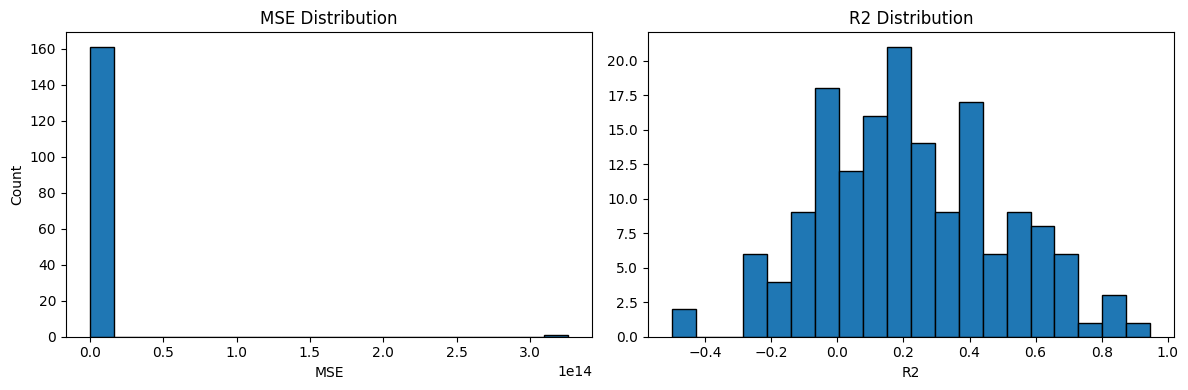

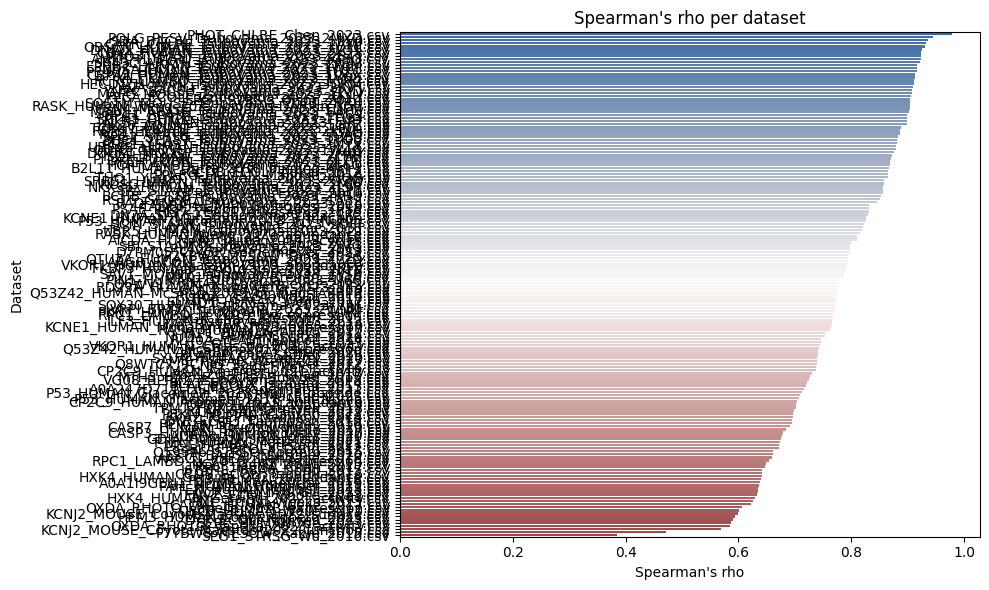

In [11]:
import os
import glob
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import spearmanr
from vae_module import Config, Tokenizer, load_vae, encode_batch
import torch

# -------- Configuration --------
DATA_DIR = '/kaggle/input/dms-subs/DMS_ProteinGym_substitutions/'
OUTPUT_DIR = '/kaggle/working/models/'
os.makedirs(OUTPUT_DIR, exist_ok=True)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# VAE setup
cfg = Config(model_path='models/vae_epoch380.pt')
tokenizer = Tokenizer.from_esm()
vae = load_vae(cfg,
               vocab_size=len(tokenizer.vocab),
               pad_idx=tokenizer.pad_idx,
               bos_idx=tokenizer.bos_idx).to(device)
vae.eval()

# MLP hyperparameters
dense_args = {
    'hidden_layer_sizes': (128, 64),
    'activation': 'relu',
    'alpha': 9.17e-05,
    'batch_size': 64,
    'learning_rate_init': 2.29e-04,
    'max_iter': 300,
    'random_state': 42
}

def encode_sequences(sequences: List[str], cfg: Config, tokenizer: Tokenizer, model) -> torch.Tensor:
    """Encode sequences into latent vectors using the VAE model."""
    # Sequences longer than max len were previously filtered and removed
    truncated = sequences
    dataset = SequenceDataset(truncated, tokenizer, cfg.max_len)
    loader = DataLoader(
        dataset,
        batch_size=cfg.batch_size,
        collate_fn=lambda batch: pad_collate(batch, tokenizer.pad_idx),
    )
    return encode_batch(model, loader, tokenizer)

def extract_Z(seq,vae):
    vae.eval()
    Z_list= []
    dataset = SequenceDataset(seq, tokenizer, cfg.max_len)
    loader = DataLoader(
        dataset,
        batch_size=cfg.batch_size,
        collate_fn=lambda batch: pad_collate(batch, tokenizer.pad_idx),
    )
    with torch.no_grad():
        for seq_batch in loader:
            seq_batch = seq_batch.to(device)
            reps, mask = vae.encoder(seq_batch)
            mask = mask.unsqueeze(-1)
            reps = reps * mask.float()
            summed = reps.sum(dim=1)
            counts = mask.sum(dim=1).clamp(min=1)
            z = (summed / counts).cpu().numpy()
            Z_list.append(z)

    return np.vstack(Z_list)


# Gather results
results = []
rhos = []
datasets = []

# -------- Process each CSV --------
for filepath in glob.glob(os.path.join(DATA_DIR, '*.csv')):
    name = os.path.basename(filepath)
    df = pd.read_csv(filepath)
    df['true_len'] = df['mutated_sequence'].str.len()
    df = df[df['true_len'] <= 512].reset_index(drop=True)
    if df.empty:
        continue

    # Encode sequences via VAE
    sequences = df['mutated_sequence'].tolist()
    with torch.no_grad():
        z = encode_sequences(sequences, cfg, tokenizer, vae)
    X = z.cpu().numpy().astype(np.float32)
    y = df['DMS_score'].values.astype(np.float32)

    # Split and scale
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    X_scaler = StandardScaler().fit(X_train)
    y_scaler = StandardScaler().fit(y_train.reshape(-1,1))
    X_train_s = X_scaler.transform(X_train)
    X_test_s  = X_scaler.transform(X_test)
    y_train_s = y_scaler.transform(y_train.reshape(-1,1)).ravel()

    # Fit MLP
    model = MLPRegressor(**dense_args).fit(X_train_s, y_train_s)

    # Predict and invert scale
    y_pred_s = model.predict(X_test_s)
    y_pred   = y_scaler.inverse_transform(y_pred_s.reshape(-1,1)).ravel()

    # Metrics
    mse = mean_squared_error(y_test, y_pred)
    r2  = r2_score(y_test, y_pred)
    results.append({'dataset': name, 'n_samples': len(df),
                    'n_features': X.shape[1], 'MSE': mse, 'R2': r2})

    # Save model
    joblib.dump({'model': model,
                 'X_scaler': X_scaler,
                 'y_scaler': y_scaler},
                os.path.join(OUTPUT_DIR, f"mlp_{os.path.splitext(name)[0]}.joblib"))

    # Spearman rho on full set
    rho, _ = spearmanr(y, y_scaler.inverse_transform(model.predict(X_scaler.transform(X)).reshape(-1,1)).ravel())
    rhos.append(rho)
    datasets.append(name)
    print(f"{name}: MSE={mse:.3f}, R2={r2:.3f}, rho={rho:.3f}")

# -------- Summarize --------
results_df = pd.DataFrame(results)
results_df.to_csv('/kaggle/working/batch_results.csv', index=False)

# Histograms of MSE and R2
fig, axes = plt.subplots(1,2, figsize=(12,4))
axes[0].hist(results_df['MSE'], bins=20, edgecolor='black')
axes[0].set(title='MSE Distribution', xlabel='MSE', ylabel='Count')
axes[1].hist(results_df['R2'], bins=20, edgecolor='black')
axes[1].set(title='R2 Distribution', xlabel='R2')
plt.tight_layout()
plt.show()

# Spearman rho bar plot
rho_df = pd.DataFrame({'dataset': datasets, 'rho': rhos}).sort_values('rho', ascending=False)
plt.figure(figsize=(10,6))
sns.barplot(x='rho', y='dataset', data=rho_df, palette='vlag')
plt.axvline(0, color='k', linestyle='--')
plt.title("Spearman's rho per dataset")
plt.xlabel("Spearman's rho")
plt.ylabel('Dataset')
plt.tight_layout()
plt.show()
